In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import ROOT
from ROOT import TFile, TTree, TH1F, TCanvas, TAxis, TLegend, TTreeReader, TTreeReaderValue, TRandom3
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler

Welcome to JupyROOT 6.22/06


In [2]:
def make_df(outTree):
    data, columns = outTree.AsMatrix(return_labels=True)
    df_temp = pd.DataFrame(data=data, columns=columns)
    df = df_temp.iloc[:, :len(df_temp.columns)-1]
    label = df_temp.iloc[:, len(df_temp.columns)-1:len(df_temp.columns)]
    return df, label

In [3]:
def eval_regreesion(df, label, model):
    # Plot BDT output
    sig_index_list = np.where((label.values.ravel() == 1))[0].tolist()
    bkg_index_list = np.where((label.values.ravel() == 0))[0].tolist()
    print("Number of signals for testing: ", len(sig_index_list))
    print("Number of backgrounds for testing: ", len(bkg_index_list))
    result_sig = clf.predict(df.iloc[sig_index_list])
    result_bkg = clf.predict(df.iloc[bkg_index_list])
    max_sig_response = max(result_sig)
    max_bkg_response = max(result_bkg)
    max_response = max([max_sig_response, max_bkg_response])
    # Manually calculate classificiation efficiency
    sig_eff_list = []
    bkg_rej_list = []
    sig_purity_list = []
    sensitivity_list = []
    cut_list = []
    cut_90eff = -1
    for cut in np.linspace(0,1,101):
        N_sig = len(sig_index_list)
        N_bkg = len(bkg_index_list)
        N_sig_pass = len([x for x in result_sig if x > cut])
        N_bkg_pass = len([x for x in result_bkg if x > cut])
        if(N_bkg_pass == 0 or (N_sig_pass + N_bkg_pass) == 0):
            print("Dividing zero, end loop")
            break
        cut_list.append(cut)
        sig_eff_list.append(N_sig_pass / N_sig)
        if abs((N_sig_pass / N_sig) - 0.9) < 0.02:
            print(N_sig_pass / N_sig, cut_90eff)
            cut_90eff = cut
        bkg_rej_list.append(1 - N_bkg_pass / N_bkg)
        sig_purity_list.append(N_sig_pass / (N_sig_pass + N_bkg_pass))
        sensitivity_list.append(N_sig_pass / math.sqrt(N_bkg_pass))
    fig = plt.figure()   
    ax0 = fig.add_subplot(3,1,1)
    plt.hist(result_sig,100, color='r', alpha=0.5, label="match")
    plt.hist(result_bkg,100, color='b', alpha=0.5, label="unmatch")
    ax0.set_ylabel("Events")
    ax0.set_xlabel("BDT response")
    ax0.set_xlim(-0.01,max_response+0.05)
    handles, labels = ax0.get_legend_handles_labels()
    ax0.legend(handles, labels)
    ax1 = fig.add_subplot(3,1,2)
    ax1.plot(cut_list, sig_eff_list, label="Signal efficiency", color="red")
    ax1.plot(cut_list, bkg_rej_list, label="Background rejection", color="blue")
    ax1.plot(cut_list, sig_purity_list, label="Signal purity", color="green") 
    ax1.set_ylabel("")
    ax1.set_xlabel("Cut on BDT")
    ax1.set_xlim(-0.01,max_response+0.05)
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels)
    ax1.grid(True)
    ax2 = fig.add_subplot(3,1,3)
    ax2.plot(cut_list, sensitivity_list, label=r"$S/\sqrt{B}$", color="black")
    ax2.set_ylabel("")
    ax2.set_xlabel("Cut on BDT")
    ax2.set_xlim(-0.01,max_response+0.05)
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles, labels)
    ax2.grid(True)
    fig.set_figheight(20)
    fig.set_figwidth(12)
    print("90% signal efficiency cut: ", cut_90eff)
    print("Max FOM: ", max(sensitivity_list))
    print("Original FOM: ", sensitivity_list[0])
    print("Optimal cut on BDT: ", cut_list[sensitivity_list.index(max(sensitivity_list))])
    fig.show()

In [7]:
def skim_tree(sample, outTree, isSig, N2train): 
    inFile = TFile(f"/home/xyan13/Trijet/TrijetAna/TrijetAna/ML_study_v4/samples_100pb_skimmed/{sample}.root")
    inTree = inFile.Get("Events")
    scale = N2train / inTree.GetEntries()
    print(inTree.GetEntries())
    if N2train == -1:
        scale = 1
    
    randgen = TRandom3()
    for i, event in enumerate(inTree):
        if i%10000 == 0:
            print("Processing: ",i)
        rand = randgen.Uniform()
        if(rand > scale):
            continue
        dijet_eta[0] = event.dijet_eta
        dijet_phi[0] = event.dijet_phi
        dR_jj[0] = event.dR_jj
        dEta_jj[0] = event.dEta_jj
        dPhi_jj[0] = event.dPhi_jj
        dR_j0j2[0] = event.dR_j0j2
        dEta_j0j2[0] = event.dEta_j0j2
        dPhi_j0j2[0] = event.dPhi_j0j2
        dR_j1j2[0] = event.dR_j1j2
        dEta_j1j2[0] = event.dEta_j1j2
        dPhi_j1j2[0] = event.dPhi_j1j2
        jet_eta_0[0] = event.jet_eta_0
        jet_phi_0[0] = event.jet_phi_0
        jet_ptoverm_0[0] = event.jet_ptoverm_0
        jet_eta_1[0] = event.jet_eta_1
        jet_phi_1[0] = event.jet_phi_1
        jet_ptoverm_1[0] = event.jet_ptoverm_1
        jet_eta_2[0] = event.jet_eta_2
        jet_phi_2[0] = event.jet_phi_2
        jet_ptoverm_2[0] = event.jet_ptoverm_2
        dR_jj_j[0] = event.dR_jj_j
        dEta_jj_j[0] = event.dEta_jj_j
        dPhi_jj_j[0] = event.dPhi_jj_j
        jet_ptoverM_0[0] = event.jet_ptoverM_0
        jet_ptoverM_1[0] = event.jet_ptoverM_1
        jet_ptoverM_2[0] = event.jet_ptoverM_2
        dijet_ptoverM[0] = event.dijet_ptoverM
        tag[0] = isSig
        outTree.Fill()
    return 0

In [8]:
sample_dic = {"QCD_filtered_100pbinv" : 0,
              "Res1ToRes2GluTo3Glu_M1-3000_R-0p3_filtered_match3-0" : 1}
# sample_dic = {"QCD_filtered_2fb" : 0}
tempFile = TFile(f"training.root","RECREATE")
outTree = TTree()

dijet_eta = np.empty((1), dtype="float32")
dijet_phi = np.empty((1), dtype="float32")
dR_jj = np.empty((1), dtype="float32")
dEta_jj = np.empty((1), dtype="float32")
dPhi_jj = np.empty((1), dtype="float32")
dR_j0j2 = np.empty((1), dtype="float32")
dEta_j0j2 = np.empty((1), dtype="float32")
dPhi_j0j2 = np.empty((1), dtype="float32")
dR_j1j2 = np.empty((1), dtype="float32")
dEta_j1j2 = np.empty((1), dtype="float32")
dPhi_j1j2 = np.empty((1), dtype="float32")
jet_eta_0 = np.empty((1), dtype="float32")
jet_phi_0 = np.empty((1), dtype="float32")
jet_ptoverm_0 = np.empty((1), dtype="float32")
jet_eta_1 = np.empty((1), dtype="float32")
jet_phi_1 = np.empty((1), dtype="float32")
jet_ptoverm_1 = np.empty((1), dtype="float32")
jet_eta_2 = np.empty((1), dtype="float32")
jet_phi_2 = np.empty((1), dtype="float32")
jet_ptoverm_2 = np.empty((1), dtype="float32")
dR_jj_j = np.empty((1), dtype="float32")
dEta_jj_j = np.empty((1), dtype="float32")
dPhi_jj_j = np.empty((1), dtype="float32")
jet_ptoverM_0 = np.empty((1), dtype="float32")
jet_ptoverM_1 = np.empty((1), dtype="float32")
jet_ptoverM_2 = np.empty((1), dtype="float32")
dijet_ptoverM = np.empty((1), dtype="float32")
tag = np.empty((1), dtype="float32")

outTree.Branch("dijet_eta", dijet_eta, "dijet_eta/F")
outTree.Branch("dijet_phi", dijet_phi, "dijet_phi/F")
outTree.Branch("dR_jj", dR_jj, "dR_jj/F")
outTree.Branch("dEta_jj", dEta_jj, "dEta_jj/F")
outTree.Branch("dPhi_jj", dPhi_jj, "dPhi_jj/F")
outTree.Branch("dR_j0j2", dR_j0j2, "dR_j0j2/F")
outTree.Branch("dEta_j0j2", dEta_j0j2, "dEta_j0j2/F")
outTree.Branch("dPhi_j0j2", dPhi_j0j2, "dPhi_j0j2/F")
outTree.Branch("dR_j1j2", dR_j1j2, "dR_j1j2/F")
outTree.Branch("dEta_j1j2", dEta_j1j2, "dEta_j1j2/F")
outTree.Branch("dPhi_j1j2", dPhi_j1j2, "dPhi_j1j2/F")
outTree.Branch("jet_eta_0", jet_eta_0, "jet_eta_0/F")
outTree.Branch("jet_phi_0", jet_phi_0, "jet_phi_0/F")
outTree.Branch("jet_ptoverm_0", jet_ptoverm_0, "jet_ptoverm_0/F")
outTree.Branch("jet_eta_1", jet_eta_1, "jet_eta_1/F")
outTree.Branch("jet_phi_1", jet_phi_1, "jet_phi_1/F")
outTree.Branch("jet_ptoverm_1", jet_ptoverm_1, "jet_ptoverm_1/F")
outTree.Branch("jet_eta_2", jet_eta_2, "jet_eta_2/F")
outTree.Branch("jet_phi_2", jet_phi_2, "jet_phi_2/F")
outTree.Branch("jet_ptoverm_2", jet_ptoverm_2, "jet_ptoverm_2/F")
outTree.Branch("dR_jj_j", dR_jj_j, "dR_jj_j/F")
outTree.Branch("dEta_jj_j", dEta_jj_j, "dEta_jj_j/F")
outTree.Branch("dPhi_jj_j", dPhi_jj_j, "dPhi_jj_j/F")
outTree.Branch("jet_ptoverM_0", jet_ptoverM_0, "jet_ptoverM_0/F")
outTree.Branch("jet_ptoverM_1", jet_ptoverM_1, "jet_ptoverM_1/F")
outTree.Branch("jet_ptoverM_2", jet_ptoverM_2, "jet_ptoverM_2/F")
outTree.Branch("dijet_ptoverM", dijet_ptoverM, "dijet_ptoverM/F")
outTree.Branch("tag", tag, "tag/F")

N2train = 25000
for sample in sample_dic.keys():
    skim_tree(sample, outTree, sample_dic[sample], N2train)

df = pd.DataFrame()
label = pd.DataFrame()
df, label = make_df(outTree)
X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.33, random_state=1, stratify=label)

164320
Processing:  0
Processing:  10000
Processing:  20000
Processing:  30000
Processing:  40000
Processing:  50000
Processing:  60000
Processing:  70000
Processing:  80000
Processing:  90000
Processing:  100000
Processing:  110000
Processing:  120000
Processing:  130000
Processing:  140000
Processing:  150000
Processing:  160000
24649
Processing:  0
Processing:  10000
Processing:  20000


In [9]:
# This cell is intended for the single traning
df_train = X_train
label_train = y_train
df_test = X_test
label_test = y_test
display(df_train.head())
display(label_train.head(15))
label_arr = np.array(label_train.iloc[1:,:]).ravel()
all_N = np.shape(label_arr)
sig_N = np.shape(np.where(label_arr == 1))
print(all_N, sig_N)

,dijet_eta,dijet_phi,dR_jj,dEta_jj,dPhi_jj,dR_j0j2,dEta_j0j2,dPhi_j0j2,dR_j1j2,dEta_j1j2,...,jet_eta_2,jet_phi_2,jet_ptoverm_2,dR_jj_j,dEta_jj_j,dPhi_jj_j,jet_ptoverM_0,jet_ptoverM_1,jet_ptoverM_2,dijet_ptoverM
43091,-0.682337,0.148123,1.539262,1.443237,0.535156,3.025800,0.042969,3.025495,3.101774,1.486206,...,-0.953491,-3.004395,1.261281,3.142388,0.271154,3.130667,0.386911,0.097438,0.408919,0.473341
44973,0.155623,2.634525,1.309350,1.024048,0.815918,2.827922,0.115509,2.825562,2.793573,0.908539,...,-0.230194,-0.562378,1.593271,3.110305,0.385817,3.086282,0.241273,0.203568,0.478737,0.408608
32412,-0.695866,2.979857,1.300904,0.950989,0.887677,2.946038,0.262085,2.934357,2.555749,0.688904,...,-0.622192,-0.200958,1.455730,3.103245,0.073674,3.102370,0.354920,0.144758,0.445636,0.460199
7554,2.203571,-1.604360,2.874358,0.600586,2.810913,3.122530,1.041870,2.943586,0.688652,0.441284,...,0.466919,1.479492,0.664483,3.539224,1.736652,3.083853,0.376082,0.171917,0.351243,0.220656
49420,-0.077887,0.372626,1.305302,0.291492,1.272339,2.939193,0.002819,2.939191,2.092457,0.294312,...,0.029785,-2.605469,1.153272,2.980040,0.107672,2.978095,0.412131,0.187290,0.398073,0.500324


,tag
43091,1.0
44973,1.0
32412,1.0
7554,0.0
49420,1.0
28628,1.0
27669,1.0
48643,1.0
462,0.0
5384,0.0


(33272,) (1, 16514)


In [ ]:
# This cell is intended for mix traning using two samples
N2train = min(X_train_1.shape[0], X_train_2.shape[0])
print(N2train)
df_train = pd.concat([X_train_1.iloc[:N2train, :], X_train_2.iloc[:N2train, :]])
label_train = pd.concat([y_train_1.iloc[:N2train, :], y_train_2.iloc[:N2train, :]])
print(df_train.shape[0])
N2test = min(X_test_1.shape[0], X_test_2.shape[0])
print(N2test)
df_test = pd.concat([X_test_1.iloc[:N2test, :], X_test_2.iloc[:N2test, :]])
label_test = pd.concat([y_test_1.iloc[:N2test, :], y_test_2.iloc[:N2test, :]])
print(df_test.shape[0])

['dijet_eta', 'dijet_phi', 'dR_jj', 'dEta_jj', 'dPhi_jj', 'dR_j0j2', 'dEta_j0j2', 'dPhi_j0j2', 'dR_j1j2', 'dEta_j1j2', 'dPhi_j1j2', 'jet_eta_0', 'jet_phi_0', 'jet_ptoverm_0', 'jet_eta_1', 'jet_phi_1', 'jet_ptoverm_1', 'jet_eta_2', 'jet_phi_2', 'jet_ptoverm_2', 'dR_jj_j', 'dEta_jj_j', 'dPhi_jj_j', 'jet_ptoverM_0', 'jet_ptoverM_1', 'jet_ptoverM_2', 'dijet_ptoverM']


,PC1,PC2,tag
0,-4.355558,0.076985,0.0
1,-1.891741,3.285926,0.0
2,1.637815,1.620926,0.0
3,2.018088,0.208221,0.0
4,-2.648397,3.185672,0.0


dR_jj            0.349300
jet_ptoverM_2    0.341427
dijet_ptoverM    0.332041
dtype: float64

jet_ptoverM_0    0.390163
dR_j1j2          0.346052
dR_jj_j          0.344714
dtype: float64

dPhi_j0j2    0.497126
dR_j0j2      0.368216
dPhi_jj_j    0.357331
dtype: float64

dijet_eta    0.609483
jet_eta_0    0.524496
jet_eta_1    0.432936
dtype: float64

dijet_phi    0.559962
jet_phi_0    0.547660
jet_phi_2    0.470576
dtype: float64

dEta_jj          0.621964
jet_ptoverm_1    0.367698
dEta_jj_j        0.269396
dtype: float64

dEta_j1j2        0.537542
jet_ptoverM_1    0.398392
jet_ptoverm_0    0.299579
dtype: float64

jet_phi_1    0.962821
jet_phi_0    0.203247
jet_phi_2    0.110679
dtype: float64

jet_eta_2    0.991476
jet_phi_1    0.098304
jet_eta_1    0.063344
dtype: float64

dPhi_jj_j    0.534745
dEta_j1j2    0.388701
dEta_j0j2    0.380046
dtype: float64

jet_eta_1    0.808898
jet_eta_0    0.579869
dijet_eta    0.073637
dtype: float64

jet_phi_2    0.841912
dijet_phi    0.356188
jet_phi_0    0.346729
dtype: float64

dijet_ptoverM    0.452479
jet_ptoverm_2    0.448547
jet_ptoverM_0    0.329577
dtype: float64

jet_ptoverM_2    0.434954
dPhi_jj_j        0.433760
dPhi_j0j2        0.351961
dtype: float64

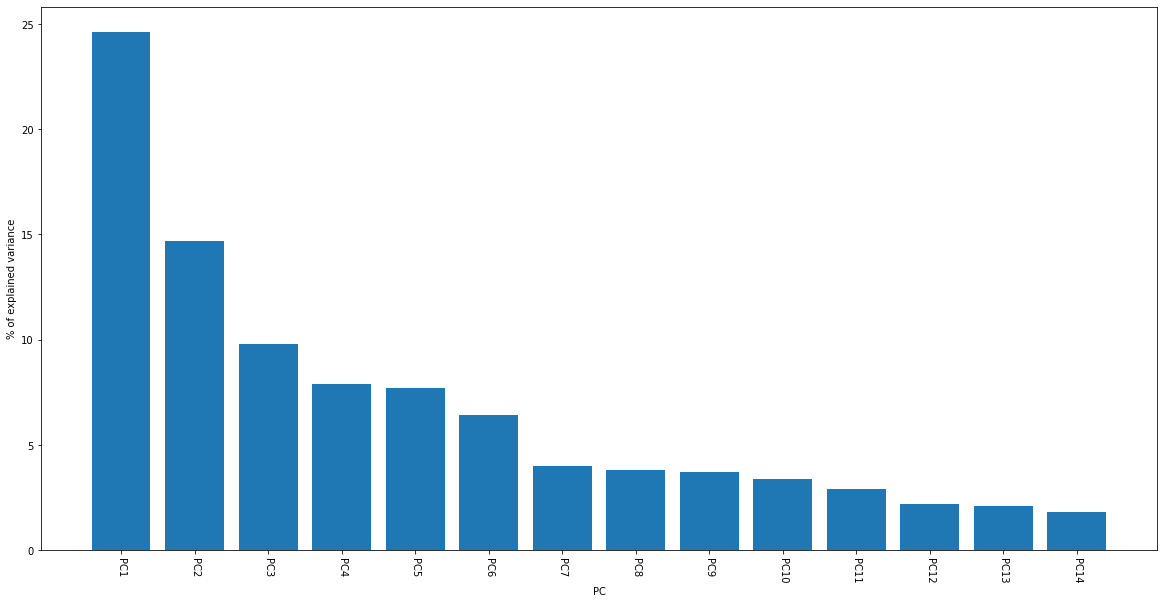

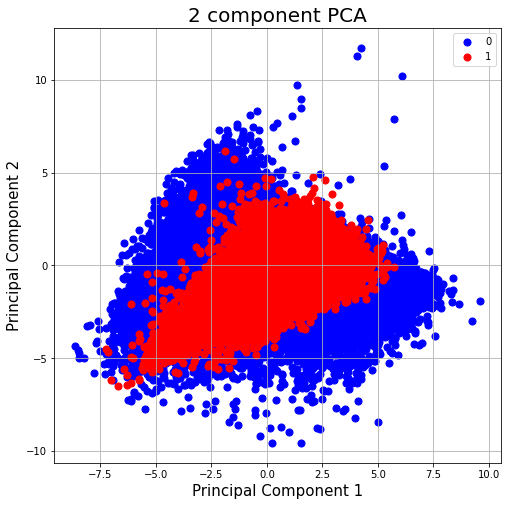

In [10]:
# This cell is intended for PCA analysis, can be run seperately from ML traning
variables = [var for var in df.columns[:len(df.columns)]]
print(variables)
scaled_df = preprocessing.scale(df)
pca = PCA(0.95)
pca.fit(scaled_df)
PCA_df = pca.transform(scaled_df)
PCA_df = pd.DataFrame(data = PCA_df[:,:2],columns = ["PC1","PC2"])
PCA_df_final = pd.concat([PCA_df,label] ,axis = 1)
display(PCA_df_final.head())
# Calculate percentage variation
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals = 1)
# Calculate loading scores, determine best variables of each PCs
for i in range(0, len(per_var)):
    loading_scores = pd.Series(pca.components_[i], index=variables)
    loading_scores = loading_scores.abs().sort_values(ascending=False)
    display(loading_scores[:3])
labels = ["PC" + str(x) for x in range(1, len(per_var)+1)]
plt.figure(figsize=(20,10))
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel("% of explained variance")
plt.xlabel("PC")
plt.xticks(rotation=270)
plt.show()
# display(pca.components_)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1]
colors = ["b","r"]
for target, color in zip(targets,colors):
    indicesToKeep = PCA_df_final["tag"] == target
    ax.scatter(PCA_df_final.loc[indicesToKeep, "PC1"],
               PCA_df_final.loc[indicesToKeep, "PC2"],
               c = color,
               s = 50)
ax.legend(targets)
ax.grid()

In [11]:
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# clf = MLPClassifier(solver='adam',hidden_layer_sizes=(20,20),random_state=1)
clf = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=200, random_state=1)
clf.fit(df_train, label_train.values.ravel())
# Score the fit using the pure QCD or Signal data
# X_test = scaler.transform(X_test)
# print(clf.score(X_test,y_test.values.ravel()))

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4),
                  n_estimators=200, random_state=1)

Number of signals for testing:  8134
Number of backgrounds for testing:  8255
0.9160314728300959 -1
Dividing zero, end loop
90% signal efficiency cut:  0.54
Max FOM:  222.24857636836754
Original FOM:  89.52526789550852
Optimal cut on BDT:  0.56
Number of signals for testing:  16515
Number of backgrounds for testing:  16758
0.917045110505601 -1
Dividing zero, end loop
90% signal efficiency cut:  0.54
Max FOM:  332.03995240474126
Original FOM:  127.57556047497825
Optimal cut on BDT:  0.56


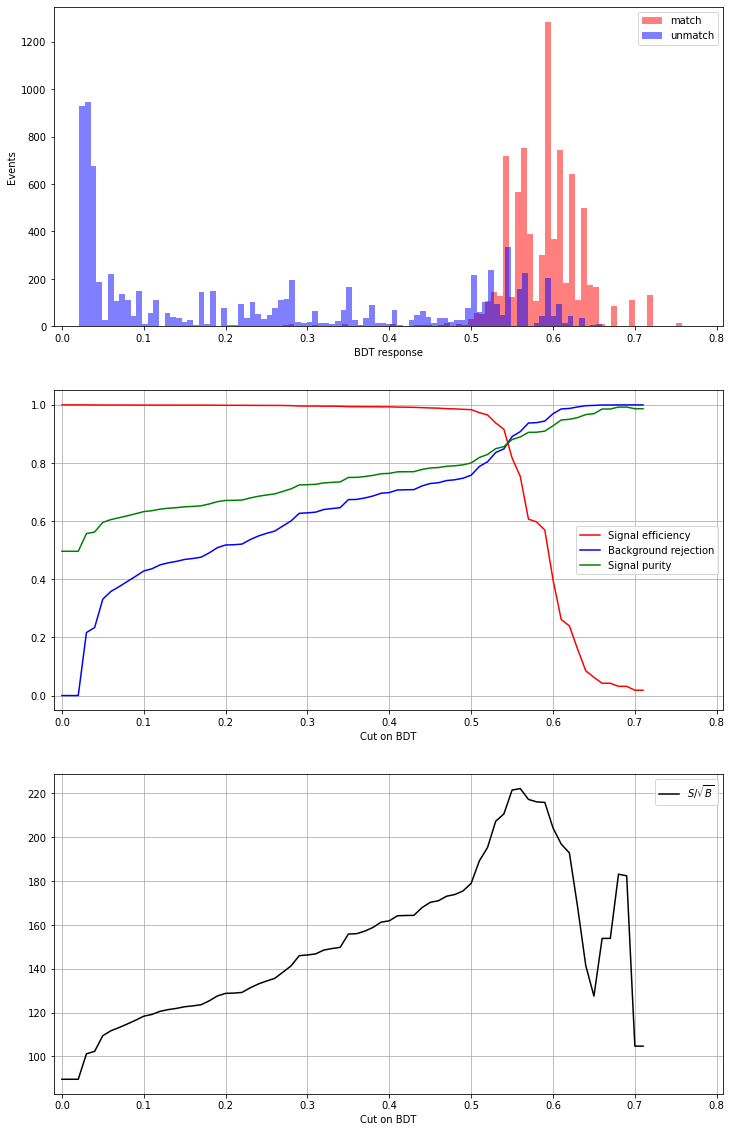

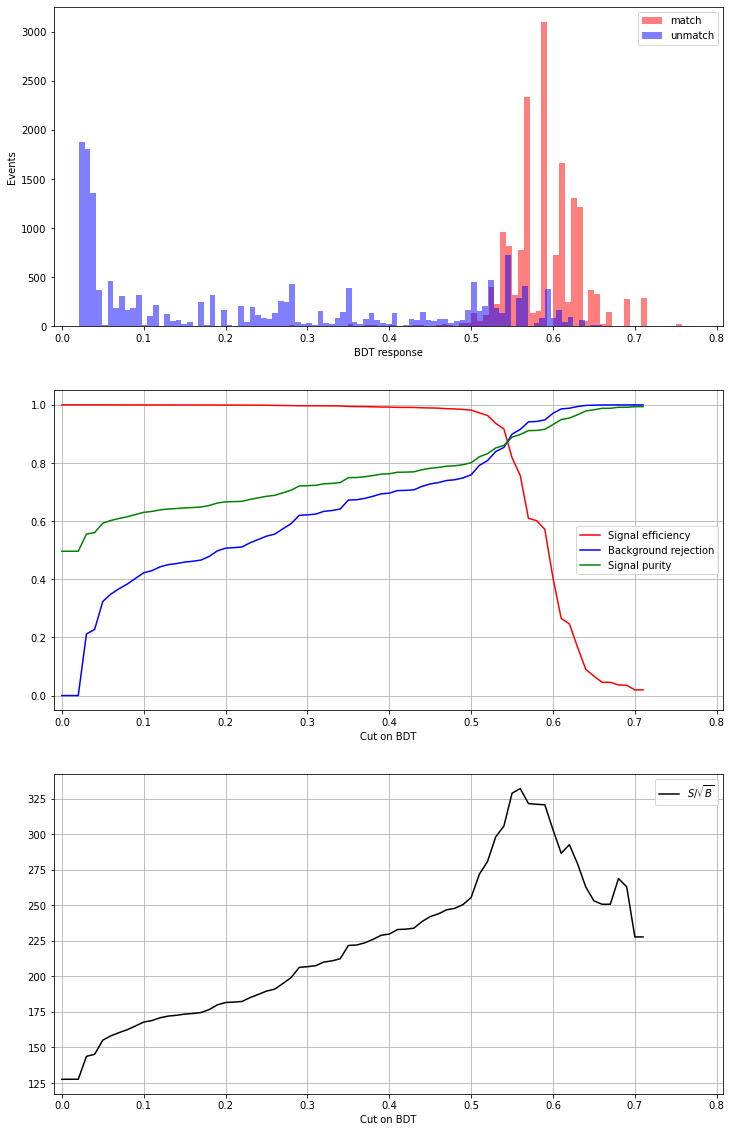

In [12]:
eval_regreesion(df_test, label_test, clf)
eval_regreesion(df_train, label_train, clf)

In [13]:
from joblib import dump, load
dump(clf, 'BDT_model_QCD_sig0p3_matching3.joblib') 

['BDT_model_QCD_sig0p3_matching3.joblib']

164320
Processing:  0
Processing:  10000
Processing:  20000
Processing:  30000
Processing:  40000
Processing:  50000
Processing:  60000
Processing:  70000
Processing:  80000
Processing:  90000
Processing:  100000
Processing:  110000
Processing:  120000
Processing:  130000
Processing:  140000
Processing:  150000
Processing:  160000
28264
Processing:  0
Processing:  10000
Processing:  20000
Number of signals for testing:  24999
Number of backgrounds for testing:  25013
0.9012360494419777 -1
Dividing zero, end loop
90% signal efficiency cut:  0.54
Max FOM:  437.3048952716759
Original FOM:  158.06646651306315
Optimal cut on BDT:  0.68


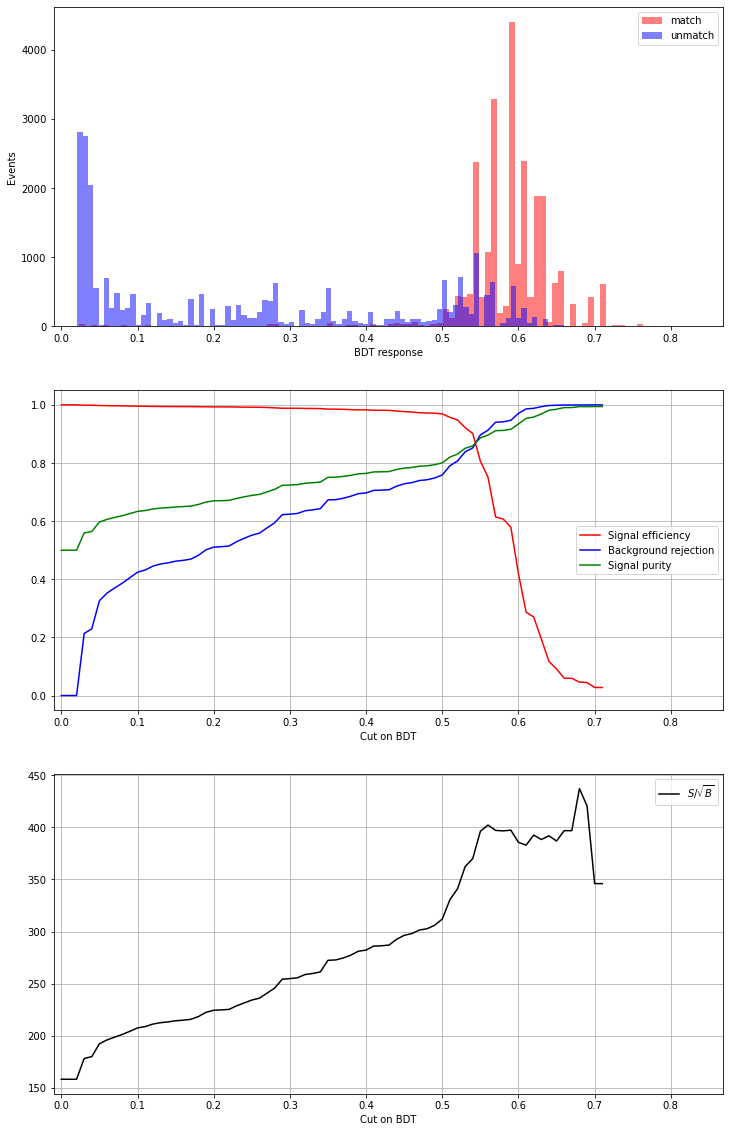

In [15]:
clf = load('BDT_model_QCD_sig0p3_matching3.joblib') 
sample_dic = {"QCD_filtered_100pbinv" : 0,
              "Res1ToRes2GluTo3Glu_M1-7000_R-0p3_filtered_match3-0" : 1}
# sample_dic = {"QCD_filtered_2fb" : 0}
tempFile = TFile(f"training.root","RECREATE")
outTree = TTree()

dijet_eta = np.empty((1), dtype="float32")
dijet_phi = np.empty((1), dtype="float32")
dR_jj = np.empty((1), dtype="float32")
dEta_jj = np.empty((1), dtype="float32")
dPhi_jj = np.empty((1), dtype="float32")
dR_j0j2 = np.empty((1), dtype="float32")
dEta_j0j2 = np.empty((1), dtype="float32")
dPhi_j0j2 = np.empty((1), dtype="float32")
dR_j1j2 = np.empty((1), dtype="float32")
dEta_j1j2 = np.empty((1), dtype="float32")
dPhi_j1j2 = np.empty((1), dtype="float32")
jet_eta_0 = np.empty((1), dtype="float32")
jet_phi_0 = np.empty((1), dtype="float32")
jet_ptoverm_0 = np.empty((1), dtype="float32")
jet_eta_1 = np.empty((1), dtype="float32")
jet_phi_1 = np.empty((1), dtype="float32")
jet_ptoverm_1 = np.empty((1), dtype="float32")
jet_eta_2 = np.empty((1), dtype="float32")
jet_phi_2 = np.empty((1), dtype="float32")
jet_ptoverm_2 = np.empty((1), dtype="float32")
dR_jj_j = np.empty((1), dtype="float32")
dEta_jj_j = np.empty((1), dtype="float32")
dPhi_jj_j = np.empty((1), dtype="float32")
jet_ptoverM_0 = np.empty((1), dtype="float32")
jet_ptoverM_1 = np.empty((1), dtype="float32")
jet_ptoverM_2 = np.empty((1), dtype="float32")
dijet_ptoverM = np.empty((1), dtype="float32")
tag = np.empty((1), dtype="float32")

outTree.Branch("dijet_eta", dijet_eta, "dijet_eta/F")
outTree.Branch("dijet_phi", dijet_phi, "dijet_phi/F")
outTree.Branch("dR_jj", dR_jj, "dR_jj/F")
outTree.Branch("dEta_jj", dEta_jj, "dEta_jj/F")
outTree.Branch("dPhi_jj", dPhi_jj, "dPhi_jj/F")
outTree.Branch("dR_j0j2", dR_j0j2, "dR_j0j2/F")
outTree.Branch("dEta_j0j2", dEta_j0j2, "dEta_j0j2/F")
outTree.Branch("dPhi_j0j2", dPhi_j0j2, "dPhi_j0j2/F")
outTree.Branch("dR_j1j2", dR_j1j2, "dR_j1j2/F")
outTree.Branch("dEta_j1j2", dEta_j1j2, "dEta_j1j2/F")
outTree.Branch("dPhi_j1j2", dPhi_j1j2, "dPhi_j1j2/F")
outTree.Branch("jet_eta_0", jet_eta_0, "jet_eta_0/F")
outTree.Branch("jet_phi_0", jet_phi_0, "jet_phi_0/F")
outTree.Branch("jet_ptoverm_0", jet_ptoverm_0, "jet_ptoverm_0/F")
outTree.Branch("jet_eta_1", jet_eta_1, "jet_eta_1/F")
outTree.Branch("jet_phi_1", jet_phi_1, "jet_phi_1/F")
outTree.Branch("jet_ptoverm_1", jet_ptoverm_1, "jet_ptoverm_1/F")
outTree.Branch("jet_eta_2", jet_eta_2, "jet_eta_2/F")
outTree.Branch("jet_phi_2", jet_phi_2, "jet_phi_2/F")
outTree.Branch("jet_ptoverm_2", jet_ptoverm_2, "jet_ptoverm_2/F")
outTree.Branch("dR_jj_j", dR_jj_j, "dR_jj_j/F")
outTree.Branch("dEta_jj_j", dEta_jj_j, "dEta_jj_j/F")
outTree.Branch("dPhi_jj_j", dPhi_jj_j, "dPhi_jj_j/F")
outTree.Branch("jet_ptoverM_0", jet_ptoverM_0, "jet_ptoverM_0/F")
outTree.Branch("jet_ptoverM_1", jet_ptoverM_1, "jet_ptoverM_1/F")
outTree.Branch("jet_ptoverM_2", jet_ptoverM_2, "jet_ptoverM_2/F")
outTree.Branch("dijet_ptoverM", dijet_ptoverM, "dijet_ptoverM/F")
outTree.Branch("tag", tag, "tag/F")

N2train = 25000
for sample in sample_dic.keys():
    skim_tree(sample, outTree, sample_dic[sample], N2train)

df = pd.DataFrame()
label = pd.DataFrame()
df, label = make_df(outTree)
eval_regreesion(df, label, clf)